In [10]:
%matplotlib inline
%config IPCompleter.greedy=True

from copy import deepcopy
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math as math
import scipy.stats as st
import auxiliary_functions as aux
import dfa_functions as dfaf
from scipy.optimize import curve_fit


pd.options.display.max_rows = 10

# Run the script to load the data (the series and their segmentation) and to delete all segments with indeterminate stage or whose max frequency is below 85%
from load_data import load_data, redo_classification
data, seg_res = load_data(filter = 0)
# Reclassificates the segments using the 4 stage system.
seg_res = redo_classification(seg_res, data)


## Detrended Fluctuation Analysis
***

### Description

It's possible to ask, for any nonstationary time-series, about the cause of the fluctuations, if they occur because of some internal non-linear behaviour or if they are caused by external conditions. If we separate those fluctuations by its causes (internal or external), it's possible to presume that the internal fluctuations can show particular correlations, corresponding to the dynamics of the system. HRV time-series, particularly, have long-term Power Law correlations (a correlation that can be described by $y = a\cdot x^k$, where $a$ and $k$ are constants) for healthy individuals, so that variations of the fractal property (self-similarity after scale changes) of those correlations can be a way of detecting disturbances.

Detrended Fluctuation Analysis can be used to detect those long-term correlations, distinguishing then from external perturbations, seen as tendencies.

Given a HRV time-series of size $N$, we integrate it, $y(k) = \sum_{i=1}^k [B(i) - B_m]$, where $B(i)$ is the $\textit{i}$th interval between heart beats and $B_m$ is the average interval, and $k$ varies between $1$ and $N$. The resulting series is divided in equal sized boxes of size $n$, the scale, and in each box a polynomial curve, the tendency, is calculated using least squares. We denote the $y$ coordenate of the polynominal as $y_n(k)$. Then, the series $y(k)$ is detrended by subtracting $y_n(k)$ in each box. The value $F(n)$ given by $$F(n) = \sqrt{\dfrac{1}{N}\cdot\sum_{k=1}^N [y(k) - y_n(k)]^2}$$ is the average fluctuation in each box as a function of the scale $n$. In order to find a relation between $F(n)$ and $n$, $F(n)$ is computed for a range $n$ values. A linear relation in logarithmic scale ($log_{10}F(n)$ and $log_{10}n$) indicates a Power Law characterized by a coefficient $\alpha$, which can be interpreted in different ways depending on its range of values. For uncorrelated data, the scale exponent is $\alpha = 0.5$. For short-range correlated data, $\alpha > 0.5$ for small scales. Power-law behavior with $\alpha > 0.5$ on large scales indicates long-range correlations in the data

In [ ]:
def dfa(series, order = 1, min_n = 20):
    max_n = len(series)
    

In [328]:
df = pd.DataFrame(columns = ["n", "F(L)"], index = range(20, 10001))
df["n"] = np.zeros(10001 - 20)
df["F(L)"] = np.zeros(10001 - 20)

In [329]:
F = [[[], [], [], []],
     [[], [], [], []],
     [[], [], [], []]]
# F[grupo][serie]
F_temp = [deepcopy(df), deepcopy(df), deepcopy(df), deepcopy(df)]
# F[grupo][serie][fase]

In [330]:
g = 1
serie = 2
order = 1
colors  = ["gold", "lightsteelblue", "orchid", "lightcoral"]
t_serie = ["Serie 0", "Serie 1", "Serie 2", "Serie 3"]
t_serie_nome = ["SBP", "DBP", "BBI-BP (ms)", "BBI-KG (ms)"]
t_grupo = ["Hypertensive", "Normotensive", "Proband"]

In [344]:
for g in range(3):
    for serie in range(4): 
        F_temp = [deepcopy(df), deepcopy(df), deepcopy(df), deepcopy(df)]
        for ind in range(len(data[g])):
            series = data[g][ind][t_serie[serie]]
            for stage in range(4):
                segmentation = seg_res[g][ind][serie].where(seg_res[g][ind][serie]["SleepStage"] == stage).dropna()
                for idx in segmentation.index:
                    start = int(segmentation.loc[idx]["start"])
                    finish = int(segmentation.loc[idx]["finish"])
                    seg_series = series[start: finish+1].values
                    walk = np.cumsum(seg_series - np.mean(seg_series))
                    L = len(seg_series)
                    windows = np.arange(20, L+1, 1)

                    for n in windows:
                        x = np.arange(n)
                        w_points_fwrd = np.arange(0, L+1, n)
                        w_points_bkwrd = np.arange(L, -1, -n)

                        n_windows = 2*len(w_points_fwrd) # = 2*len(w_points_bkwrd)
                        fluc = np.asarray([])
                        for i in range(1, len(w_points_fwrd)):
                            tpoly = np.polyfit(x, walk[w_points_fwrd[i-1]: w_points_fwrd[i]], order)
                            y = np.polyval(tpoly, x)
                            fluc = np.concatenate( ( fluc, np.asarray([np.sqrt(np.sum((walk[w_points_fwrd[i-1]: w_points_fwrd[i]] - y)**2)/n)]) ) )

                            tpoly = np.polyfit(x, walk[w_points_bkwrd[i]: w_points_bkwrd[i-1]], order)
                            y = np.polyval(tpoly, x)
                            fluc = np.concatenate( ( fluc, np.asarray([np.sqrt(np.sum((walk[w_points_fwrd[i-1]: w_points_fwrd[i]] - y)**2)/n)]) ) )

                        f_n = np.sum(fluc)/len(fluc)
                        F_temp[stage].loc[n]["n"] += 1
                        F_temp[stage].loc[n]["F(L)"] += f_n
            
        F[g][serie] = F_temp

for g in range(3):
    for s in range(4):
        for p in range(4):
            F[g][s][p] = F[g][s][p].where(F[g][s][p]["n"] != 0).dropna()
            F[g][s][p]["F(L)"] = F[g][s][p]["F(L)"]/F[g][s][p]["n"].values

In [377]:
from scipy.optimize import curve_fit
def line(x, a, b):
    return np.power(10, a*np.log10(x) + b)

colors    = ["gold", "steelblue", "purple", "black"]
labels = ["Vigil", "Light", "Deep", "REM"]
groups = ["Hypertensive", "Normotensive", "Proband"]
series = ["SBP", "DBP", "BBI-P", "BBI-EKG"]

fig, axs = plt.subplots(nrows = 4, ncols = 3)
# Configure figure sizes and distance between axis
for item in [fig]:
    item.set_size_inches(20, 20)
    item.subplots_adjust(hspace = 0, wspace = 0.2)
        
coef_df = [pd.DataFrame(columns = ["SBP", "DBP", "BBI-P", "BBI-EKG"], index = np.arange(8)),
           pd.DataFrame(columns = ["SBP", "DBP", "BBI-P", "BBI-EKG"], index = np.arange(8)),
           pd.DataFrame(columns = ["SBP", "DBP", "BBI-P", "BBI-EKG"], index = np.arange(8))]
        
for g in range(3):
    for s in range(4):
        ax = axs[s][g]
        ax.set_yscale("log")
        ax.set_xscale("log")
        G = F[g][s]
        for k in range(4):
            x = np.log10(np.asarray(G[k].index))
            y = np.log10(G[k]["F(L)"].values)
            ax.scatter(x, y, color = colors[k], marker = '.', s = 2)

            popt, pcov = curve_fit( line, np.log10(np.asarray(G[k][:500].index)), np.log10(G[k][:500]["F(L)"].values) )
            ax.plot(x, line(x, *popt), color = colors[k], linewidth = 1, label = labels[k]+":   a: %5.3f" % popt[0])
            ax.legend(fontsize = 10, markerscale = 7, loc = 4)
        
        

# Configure title sizes
for i in range(4):
    for j in range(3):
        axs[i][j].xaxis.label.set_fontsize(20)
        axs[i][j].yaxis.label.set_fontsize(20)
        axs[i][j].xaxis.set_minor_locator(plt.NullLocator())
        axs[i][j].yaxis.set_minor_locator(plt.FixedLocator([2, 3]))
        axs[i][j].yaxis.set_major_locator(plt.NullLocator())
        

#for i in [0, 1]:
#    for j in [1, 2]:
#        axs[i][j].yaxis.set_major_locator(plt.FixedLocator([1]))
#        axs[i][j].yaxis.set_minor_locator(plt.NullLocator())
        
for i in [0, 1, 2]:
    axs[3][i].xaxis.set_major_locator(plt.FixedLocator([0, 1, 2, 3]))

axs[1][0].set_ylabel(r'$\log(F(n))$')
axs[1][0].yaxis.set_label_coords(-0.17,0)
axs[3][1].set_xlabel(r'$\log(L)$')
axs[3][1].xaxis.set_label_coords(0.5, -0.1)

axs[0][0].set_title("Hypertensive", size = 15)
axs[0][1].set_title("Normotensive", size = 15)
axs[0][2].set_title("Proband", size = 15)

axs[0][2].text(3.2, 1.4, "SBP", fontsize = 18, rotation = "vertical")
axs[1][2].text(3.5, 1.25, "DBP", fontsize = 18, rotation = "vertical")
axs[2][2].text(3.6, 2.65, "BBI-P", fontsize = 18, rotation = "vertical")
axs[3][2].text(3.6, 2.7, "BBI-EKG", fontsize = 18, rotation = "vertical")

fig.savefig("Plots/Measures/4 Groups/DFA/DFA_wline.png")
plt.close(fig)

In [378]:
from scipy.optimize import curve_fit
def line(x, a, b):
    return np.power(10, a*np.log10(x) + b)

colors    = ["gold", "steelblue", "purple", "black"]
labels = ["Vigil", "Light", "Deep", "REM"]
groups = ["Hypertensive", "Normotensive", "Proband"]
series = ["SBP", "DBP", "BBI-P", "BBI-EKG"]

fig, axs = plt.subplots(nrows = 4, ncols = 3)
# Configure figure sizes and distance between axis
for item in [fig]:
    item.set_size_inches(20, 20)
    item.subplots_adjust(hspace = 0, wspace = 0.2)
        
coef_df = [pd.DataFrame(columns = ["SBP", "DBP", "BBI-P", "BBI-EKG"], index = np.arange(8)),
           pd.DataFrame(columns = ["SBP", "DBP", "BBI-P", "BBI-EKG"], index = np.arange(8)),
           pd.DataFrame(columns = ["SBP", "DBP", "BBI-P", "BBI-EKG"], index = np.arange(8))]
        
for g in range(3):
    for s in range(4):
        ax = axs[s][g]
        ax.set_yscale("log")
        ax.set_xscale("log")
        G = F[g][s]
        for k in range(4):
            x = np.log10(np.asarray(G[k].index))
            y = np.log10(G[k]["F(L)"].values)
            ax.scatter(x, y, color = colors[k], marker = '.', s = 2, label = labels[k])
            ax.legend(fontsize = 10, markerscale = 7, loc = 4)
        
        

# Configure title sizes
for i in range(4):
    for j in range(3):
        axs[i][j].xaxis.label.set_fontsize(20)
        axs[i][j].yaxis.label.set_fontsize(20)
        axs[i][j].xaxis.set_minor_locator(plt.NullLocator())
        axs[i][j].yaxis.set_minor_locator(plt.FixedLocator([2, 3]))
        axs[i][j].yaxis.set_major_locator(plt.NullLocator())
        

#for i in [0, 1]:
#    for j in [1, 2]:
#        axs[i][j].yaxis.set_major_locator(plt.FixedLocator([1]))
#        axs[i][j].yaxis.set_minor_locator(plt.NullLocator())
        
for i in [0, 1, 2]:
    axs[3][i].xaxis.set_major_locator(plt.FixedLocator([0, 1, 2, 3]))

axs[1][0].set_ylabel(r'$\log(F(n))$')
axs[1][0].yaxis.set_label_coords(-0.17,0)
axs[3][1].set_xlabel(r'$\log(L)$')
axs[3][1].xaxis.set_label_coords(0.5, -0.1)

axs[0][0].set_title("Hypertensive", size = 15)
axs[0][1].set_title("Normotensive", size = 15)
axs[0][2].set_title("Proband", size = 15)

axs[0][2].text(3.2, 1.4, "SBP", fontsize = 18, rotation = "vertical")
axs[1][2].text(3.5, 1.25, "DBP", fontsize = 18, rotation = "vertical")
axs[2][2].text(3.6, 2.65, "BBI-P", fontsize = 18, rotation = "vertical")
axs[3][2].text(3.6, 2.7, "BBI-EKG", fontsize = 18, rotation = "vertical")

fig.savefig("Plots/Measures/4 Groups/DFA/DFA_woline.png")
plt.close(fig)

***

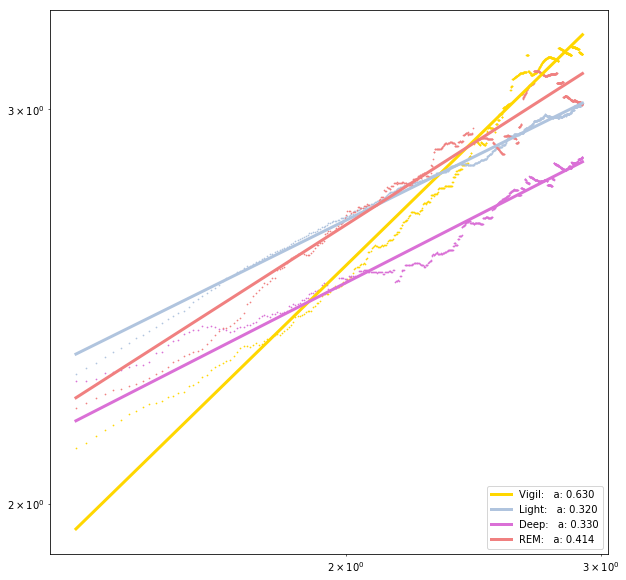

In [343]:
from scipy.optimize import curve_fit
def line(x, a, b):
    return np.power(10, a*np.log10(x) + b)

fig, ax = plt.subplots(nrows = 1, ncols = 1)
fig.set_size_inches(10, 10)
colors = ["gold", "lightsteelblue", "orchid", "lightcoral"]
labels = ["Vigil", "Light", "Deep", "REM"]

for k in range(4):
    x = np.log10(np.asarray(G[k][:800].index))
    y = np.log10(G[k][:800]["F(L)"].values)
    ax.scatter(x, y, color = colors[k], marker = '.', s = 2)
    
    popt, pcov = curve_fit( line, x, y )
    ax.plot(x, line(x, *popt), color = colors[k], linewidth = 3, label = labels[k]+":   a: %5.3f" % popt[0])
    ax.legend(fontsize = 10, markerscale = 7, loc = 4)
    
    
ax.set_xscale("log")
ax.set_yscale("log")

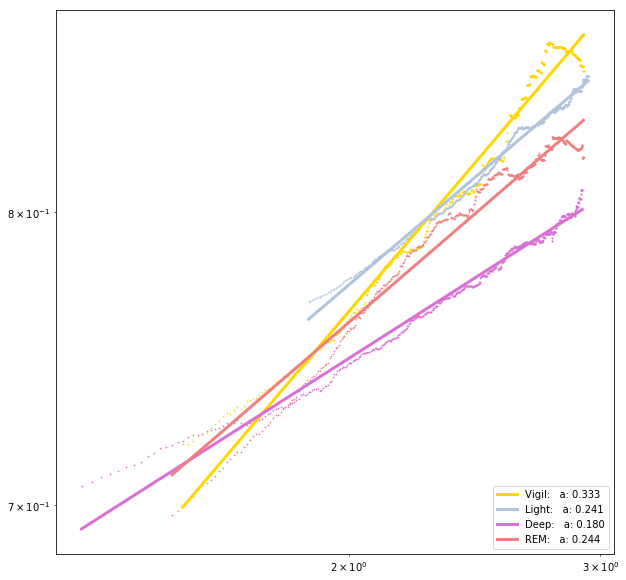

In [324]:
from scipy.optimize import curve_fit
def line(x, a, b):
    return np.power(10, a*np.log10(x) + b)

fig, ax = plt.subplots(nrows = 1, ncols = 1)
fig.set_size_inches(10, 10)
colors = ["gold", "lightsteelblue", "orchid", "lightcoral"]
labels = ["Vigil", "Light", "Deep", "REM"]

for k in range(4):
    x = np.log10(np.asarray(F[k][:800].index))
    y = np.log10(F[k][:800]["F(L)"].values)
    ax.scatter(x, y, color = colors[k], marker = '.', s = 2)
    
    popt, pcov = curve_fit( line, x, y )
    ax.plot(x, line(x, *popt), color = colors[k], linewidth = 3, label = labels[k]+":   a: %5.3f" % popt[0])
    ax.legend(fontsize = 10, markerscale = 7, loc = 4)
    
    
ax.set_xscale("log")
ax.set_yscale("log")

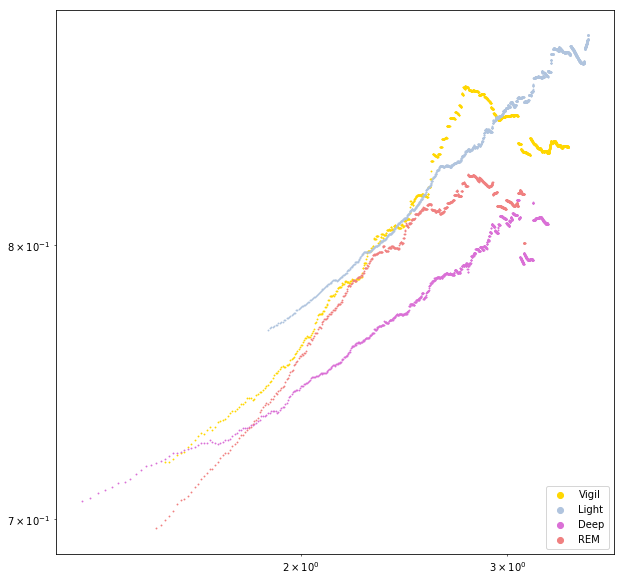

In [326]:
from scipy.optimize import curve_fit
def line(x, a, b):
    return np.power(10, a*np.log10(x) + b)

fig, ax = plt.subplots(nrows = 1, ncols = 1)
fig.set_size_inches(10, 10)
colors = ["gold", "lightsteelblue", "orchid", "lightcoral"]
labels = ["Vigil", "Light", "Deep", "REM"]

for k in range(4):
    x = np.log10(np.asarray(F[k].index))
    y = np.log10(F[k]["F(L)"].values)
    ax.scatter(x, y, color = colors[k], marker = '.', s = 3, label = labels[k])
    
    #popt, pcov = curve_fit( line, x, y )
    #ax.plot(x, line(x, *popt), color = colors[k], linewidth = 3, label = labels[k]+":   a: %5.3f" % popt[0])
    ax.legend(fontsize = 10, markerscale = 7, loc = 4)
    
    
ax.set_xscale("log")
ax.set_yscale("log")

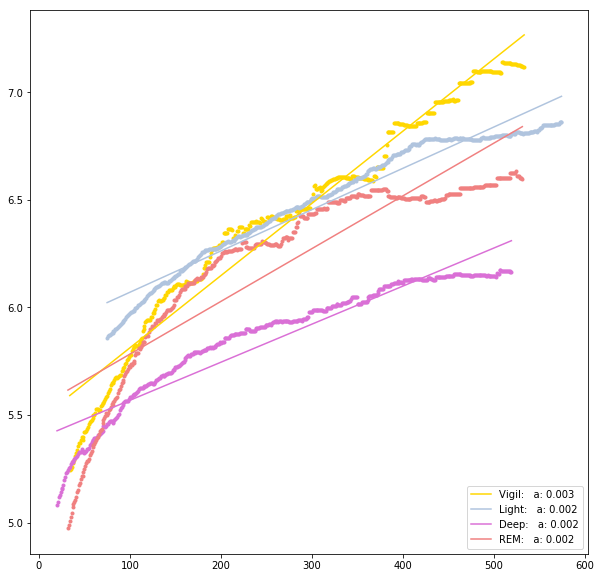

In [317]:
from scipy.optimize import curve_fit
def line(x, a, b):
    return np.power(10, a*np.log10(x) + b)

fig, ax = plt.subplots(nrows = 1, ncols = 1)
fig.set_size_inches(10, 10)
colors = ["gold", "lightsteelblue", "orchid", "lightcoral"]
labels = ["Vigil", "Light", "Deep", "REM"]

for k in range(4):
    x = np.asarray(F[k][:500].index)
    y = F[k][:500]["F(L)"].values
    ax.scatter(x, y, color = colors[k], marker = '.')
    
    pfit = np.polyfit(x, y, 1)
    pval = np.polyval(pfit, x)
    ax.plot(x, pval, color = colors[k], label =  labels[k]+":   a: %5.3f" % pfit[0])
    ax.legend(fontsize = 10, markerscale = 7, loc = 4)
    